In [1]:
%config InlineBackend.figure_format = 'svg'

# === IMPORTS ===

from typing import cast

import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import matplotlib

from pdfa import PDFA
import machines
import ffutils as ff
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode
from export import import_pdfa_json
from clock import SimpleClock

In [2]:
CORES = 12
CLOCK = SimpleClock()

STANDARD_TEST = ff.create_standard_config("test")
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")
PAUTOMAC_TEST = TestConfig(
    name = "PAutomaC",
    dir = "PAutomaC-competition_sets",
    train_suffix = ".pautomac.train.dat",
    model_suffix = ".pautomac.train.dat.ff",
    solution_suffix = ".pautomac_solution.txt",
    test_suffix = ".pautomac.test.dat"
)

def RANDOM_CONFIG(id: int) -> TestConfig:
    return ff.create_standard_config(f"random_{id}", dir="random")

def RANDOM_MACHINE(id: int) -> PDFA:
    return import_pdfa_json(input_file=f"./../models/random_{id}.json")

In [3]:
# Now my objective is to train ensemble and single model on reber grammar with increasing training set sizes

def generate_sets_size_varied(config: TestConfig, pdfa: PDFA, train_sizes: list[int], test_size: int = 0) -> None:
    # Write increasingly bigger train sets
    trainset = []
    for size in train_sizes:
        trainset = ff.write_trainset(config, pdfa, f"{config.name}_{size}", size, append_to=trainset)
    # Write test set
    if test_size > 0:
        ff.write_testset(config, pdfa, f"{config.name}", test_size)

In [21]:
def evaluate_runs(config: TestConfig, pdfa: PDFA, train_runs: list[TrainRun], test_name: str, resume_previous: bool = False, skip_training: bool = False):

    if not skip_training:
        # Train all models in a batch
        ff.train_models_batch(config, train_runs)
        print(f"Training {len(train_runs)} run configurations completed")
    else:
        print("Training models skipped")

    # List of perplexities per train run
    test_runs = TestRun.from_train_runs(train_runs, test_name)
    perplexities: list[float] = ff.test_models_batch(config, test_runs)
    print(f"Testing {len(test_runs)} run configurations on {test_name} completed")
    
    return perplexities


def plot_perplexity_by_train_size(models: list[Model], scores: dict[str, list[float]], train_sizes: list[int], plot_title: str = ""):

    # Plot the results
    plt.figure(figsize=(8, 5))
    colormap = plt.colormaps["cool"]
    get_color = lambda x : colormap(0.8 * (x + 1) / len(models))

    for i, (model_name, perplexities) in enumerate(scores.items()):
        plt.plot(train_sizes, perplexities, label=model_name, color=get_color(i))

    plt.title(f"Perplexity vs Training Set Size ({plot_title})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.xticks(train_sizes)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def evaluate_models_by_train_size(
        config: TestConfig, 
        pdfa: PDFA, 
        models: list[Model], 
        train_sizes: list[int], 
        test_size: int = 200, 
        plot_title: str|None = None, 
        skip_training: bool = False, 
        skip_generation: bool = False, 
        plotter=plot_perplexity_by_train_size
    ):

    # Set plot_title
    if not plot_title:
        plot_title = config.name

    # Generate the data for training and testing
    if not skip_training and not skip_generation:
        generate_sets_size_varied(config, pdfa, train_sizes, test_size)
        print(f"Generated {len(train_sizes)} train sets and a test set")
    else:
        print("Skipped generating training and test sets")

    # Prepare all training runs
    train_runs: list[TrainRun] = []
    for model in models:
        for train_size in train_sizes:
            run = model.into_run(run_name=f"{train_size}", trainset_name=f"{config.name}_{train_size}")
            train_runs.append(run)

    scores = evaluate_runs(config, pdfa, train_runs, test_name=config.name, skip_training=skip_training)

    # Collect the scores per model
    perplexities: dict[str, list[float]] = {model.model_name: [] for model in models}
    i = 0
    for model in models:
        for _ in train_sizes:
            perplexities[model.model_name].append(scores[i])
            i += 1
    
    # Plot the scores
    plotter(models, perplexities, train_sizes, plot_title)


Generated 10 train sets and a test set
Training 30 run configurations completed
Testing 30 run configurations on reber completed


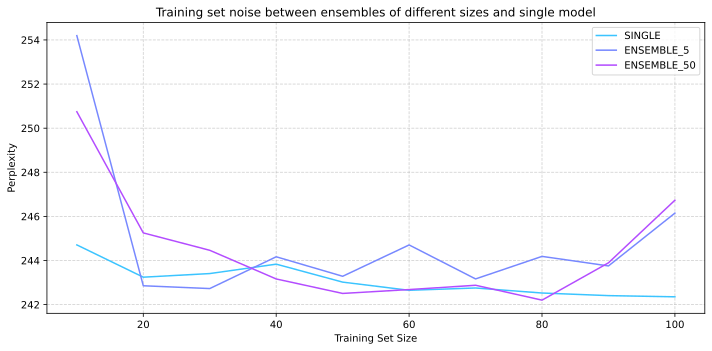

In [11]:
def plot_wide(models, scores, train_sizes, plot_title):

    # Plot the results
    plt.figure(figsize=(10, 5))
    colormap = plt.colormaps["cool"]
    get_color = lambda x : colormap(0.7 * (x + 1) / len(models))

    for i, (model_name, perplexities) in enumerate(scores.items()):
        plt.plot(train_sizes, perplexities, label=model_name, color=get_color(i))

    plt.title(f"Training set noise between ensembles of different sizes and single model")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def eval_reber_by_train_size():

    reber_train_sizes = [i for i in range(10, 101, 10)]
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Random(model_name="ENSEMBLE_5", nrestimators=5),
        Model.Random(model_name="ENSEMBLE_50", nrestimators=50)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models, reber_train_sizes, test_size=500, plotter=plot_wide)

eval_reber_by_train_size()

Generated 13 train sets and a test set
Training 39 run configurations completed
Testing 39 run configurations on reber completed


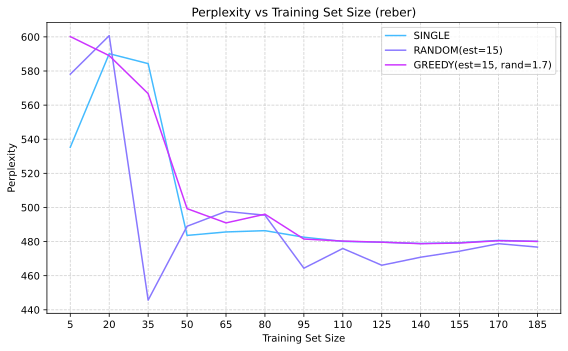

In [22]:
def eval_reber_single_random_greedy():

    reber_train_sizes = [i for i in range(5, 200, 15)]
    models = [
        Model(model_type=ModelType.SINGLE, model_name="SINGLE"),
        Model(model_type=ModelType.ENSEMBLE, model_name="RANDOM(est=15)", nrestimators=15),
        Model(model_type=ModelType.ENSEMBLE, model_name="GREEDY(est=15, rand=1.7)", nrestimators=15, ens_mode=EnsMode.GREEDY, random_factor=1.7)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.reber(), models, reber_train_sizes, test_size=1000, skip_generation=False)

eval_reber_single_random_greedy()

Generated 15 train sets and a test set
Training 30 run configurations completed
Testing 30 run configurations on parity completed


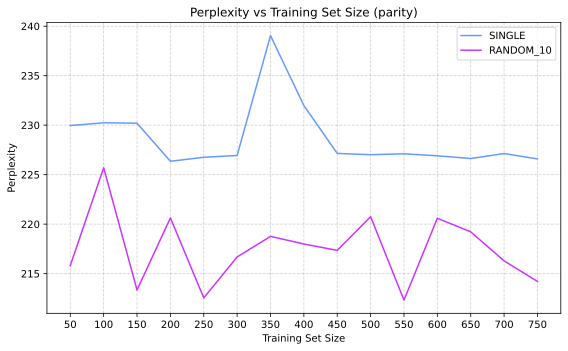

In [23]:
def eval_parity_by_train_size():

    parity_train_sizes = [i for i in range(50, 751, 50)]
    models = [
        Model(model_type=ModelType.SINGLE, model_name="SINGLE"),
        Model(model_type=ModelType.ENSEMBLE, model_name="RANDOM_10", nrestimators=10)
    ]
    evaluate_models_by_train_size(PARITY_CONFIG, machines.parity_machine(), models, parity_train_sizes, test_size=500)

eval_parity_by_train_size()

Generated 12 train sets and a test set
Training 24 run configurations completed
Testing 24 run configurations on random_1 completed


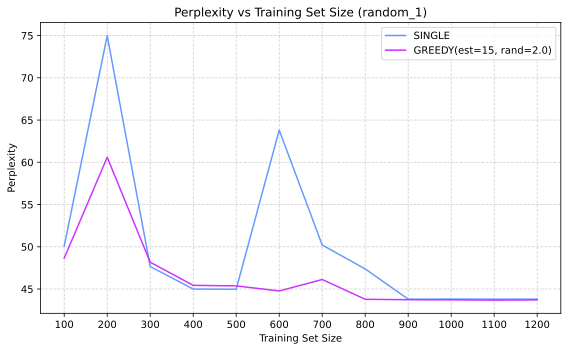

In [24]:
# Now evaluate random 1
def evaluate_random_1():

    random_1 = import_pdfa_json(input_file="./../models/random_1.json")
    random_config = ff.create_standard_config("random_1", dir="random")
    train_sizes = [i for i in range(100, 1201, 100)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.0)", nrestimators=15, rand=2.5)
    ]
    evaluate_models_by_train_size(random_config, random_1, models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_1()

Generated 13 train sets and a test set
Training 26 run configurations completed
Testing 26 run configurations completed


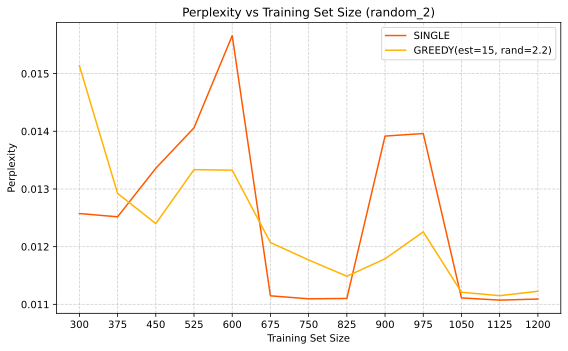

In [35]:
# Now evaluate random 2
def evaluate_random_2():

    random_2 = import_pdfa_json(input_file="./../models/random_2.json")
    random_config = ff.create_standard_config("random_2", dir="random")
    train_sizes = [i for i in range(300, 1201, 75)]
    test_size = 500
    models = [
        Model(model_type=ModelType.SINGLE, model_name="SINGLE"),
        Model(model_type=ModelType.ENSEMBLE, model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, ens_mode=EnsMode.GREEDY, random_factor=2.2)
    ]
    evaluate_models_by_train_size(random_config, random_2, models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_2()

Generated 8 train sets and a test set
Training 400 run configurations completed
Testing 400 run configurations on reber completed
Skipped generating training and test sets
Training 400 run configurations completed
Testing 400 run configurations on reber completed


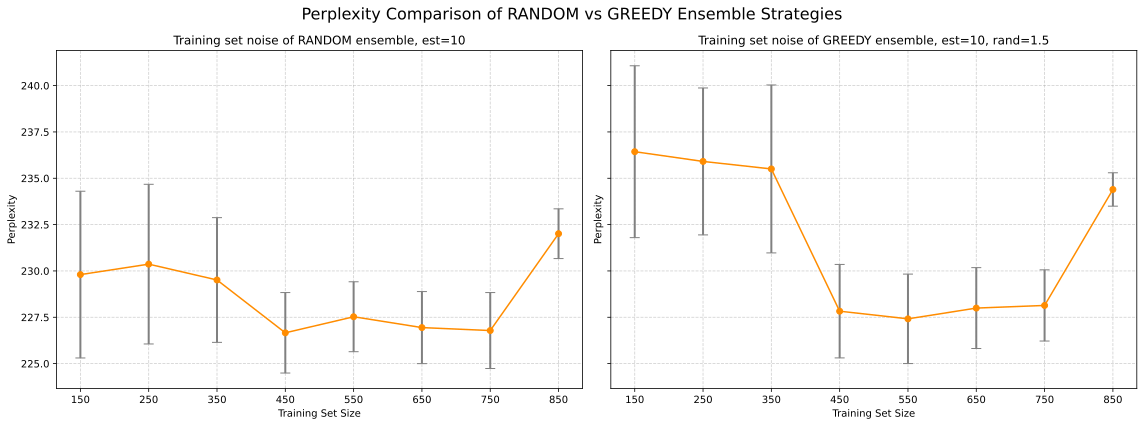

In [25]:
def plot_average_vs_trainsize(models, scores: dict[str, list[float]], train_sizes: list[int], plot_title, ax):

    # The data
    data = np.array(list(scores.values()), dtype=float)  # shape: (n_runs, training_sizes)
    means = data.mean(axis=0)
    stds = data.std(axis=0)

    # Plot
    ax.errorbar(train_sizes, means, yerr=stds, fmt='-o', capsize=5, color='darkorange', ecolor='gray', elinewidth=2)
    
    ax.set_title(f"Training set noise of {plot_title}")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("Perplexity")
    ax.set_xticks(train_sizes)
    ax.grid(True, linestyle='--', alpha=0.6)


def eval_reber_avg_random_vs_greedy():
    
    def into_plotter(ax):
        return lambda a, b, c, d: plot_average_vs_trainsize(a, b, c, d, ax=ax)

    # For plotting two graphs
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 2 plots, same y-axis

    # Run config
    reber_train_sizes = [i for i in range(150, 901, 100)]
    nrestimators = 10
    tries = 50
    test_size = 500

    models_random = [
        Model(model_type=ModelType.ENSEMBLE, model_name=f"ENS_RAND_{i}", nrestimators=nrestimators) for i in range(tries)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models_random, reber_train_sizes, test_size=test_size, plotter=into_plotter(axs[0]), plot_title="RANDOM ensemble, est=10")

    models_greedy = [
        Model(model_type=ModelType.ENSEMBLE, model_name=f"ENS_GREEDY_{i}", ens_mode=EnsMode.GREEDY, nrestimators=nrestimators, random_factor=1.5) for i in range(tries)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models_greedy, reber_train_sizes, test_size=test_size, plotter=into_plotter(axs[1]), plot_title="GREEDY ensemble, est=10, rand=1.5", skip_generation=True)

    # For plotting the graphs
    fig.suptitle("Perplexity Comparison of RANDOM vs GREEDY Ensemble Strategies", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # leave space for the suptitle
    plt.show()

eval_reber_avg_random_vs_greedy()

In [6]:
def evaluate_single_vs_ensemble(config: TestConfig, test_name: str, train_name: str):

    labels = ['SINGLE', 'ENSEMBLE']
    models = [
        Model(model_type=ModelType.SINGLE, model_name="SINGLE"),
        Model(model_type=ModelType.ENSEMBLE, model_name="ENSEMBLE_10", nrestimators=10)
    ]
    scores = []

    for model in models:
        train_run = model.into_run(trainset_name=train_name)
        ff.train_model(config, train_run)
        test_run = train_run.into_test(test_name)
        score = ff.test_model(config, test_run)
        scores.append(score)

    colors = ["blue", "orange"]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, scores, color=colors)

    # Annotate the bars with the score values
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{score:.5f}', ha='center', va='bottom')

    plt.ylabel("Perplexity Score")
    plt.title(f"SINGLE vs ENSEMBLE Perplexity ({test_name})")
    plt.ylim(0, max(scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_model_scores(config: TestConfig, runs: list[TestRun], test_name: str):

    scores = ff.test_models_batch(config, runs)
    labels = [run.run_name for run in runs]

    plt.figure(figsize=(10, 8))
    bars = plt.bar(labels, scores)

    # Annotate the bars with the score values
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{score:.5f}', ha='center', va='bottom')

    plt.ylabel("Perplexity")
    plt.title(f"Perplexity comparison ({test_name})")
    plt.ylim(0, max(scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


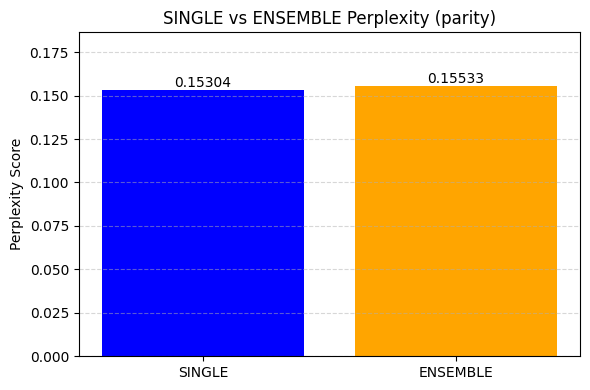

In [19]:
evaluate_single_vs_ensemble(STANDARD_TEST, "parity", "parity")

In [26]:
def scores_flat_to_normalized_distance_matrix(scores_flat: list[float], nrestimators: int) -> np.ndarray:

    # Flat array into matrix
    M = np.array(scores_flat, dtype=float).reshape((nrestimators, nrestimators))
    # Now normalize by subtracting the values from diagonal from each row
    M_diag_norm =  M - np.diag(M)[:, np.newaxis]
    # Ensure no negative values in matrix
    M_positive = np.maximum(M_diag_norm, 0) # ensure no negative
    # Make matrix symmetric
    M_sym = (M_positive + M_positive.T) / 2 # ensure symmetry

    return M_sym


def plot_nodes_by_distance(scores_flat: list[float], num_models: int, series: list[tuple[str, int]], trainset: str, print_distances=False):

    distance_matrix = scores_flat_to_normalized_distance_matrix(scores_flat, num_models)
    if print_distances:
        np.set_printoptions(threshold=100000, linewidth=100000)
        print(distance_matrix)

    reducer = UMAP(metric='precomputed', random_state=42, min_dist=0.0)
    print(reducer.fit_transform(distance_matrix))
    coords: np.ndarray = cast(np.ndarray, reducer.fit_transform(distance_matrix))

    # Plot each group in the series
    plt.figure(figsize=(10, 8))
    tot = 0
    for label, size in series:
        indices = [i for i in range(tot, tot + size)]
        tot += size
        subset = coords[indices]
        plt.scatter(subset[:, 0], subset[:, 1], s=100, label=label)  # s=100 makes points bigger
        # for i in indices:
        #     plt.text(coords[i, 0], coords[i, 1], str(i), fontsize=9, ha='center', va='center')

    plt.title(f"Model Similarities via UMAP: {trainset}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def runs_into_series(runs: list[TrainRun]) -> list[tuple[str, int]]:
    series = []
    for run in runs:
        if run.model.model_type == ModelType.SINGLE:
            series.append((run.run_name, 1))
        else:
            series.append((run.run_name, run.model.nrestimators))
    return series


def total_models(series: list[tuple[str, int]]) -> int:
    model_count = 0
    for _, models in series:
        model_count += models
    return model_count

In [27]:
def plot_models_diff_reber():

    trainset_name = "reber_30"
    ff.write_trainset(REBER_CONFIG, machines.reber(), trainset_name, 30)

    models = [
        Model(ModelType.SINGLE, "DIFF_SIN"),
        Model(ModelType.ENSEMBLE, "DIFF_GRE_05", ens_mode=EnsMode.GREEDY, nrestimators=10, random_factor=0.2),
        Model(ModelType.ENSEMBLE, "DIFF_GRE_30", ens_mode=EnsMode.GREEDY, nrestimators=10, random_factor=3.0),
        Model(ModelType.ENSEMBLE, "DIFF_RAN", ens_mode=EnsMode.RANDOM, nrestimators=10)
    ]
    for model in models:
        run = model.into_run(trainset_name=trainset_name)
        ff.train_model(REBER_CONFIG, run)

    scores_flat = ff.diff_models(REBER_CONFIG, trainset_name, [model.model_name for model in models], nrestimators=10, sample_size=200)
    models_count = 31
    plot_nodes_by_distance(scores_flat, models_count, [("SINGLE", 1), ("GREEDY(rand=0.5)", 10), ("GREEDY(rand=3.0)", 10), ("RANDOM", 10)], trainset="reber_30")

plot_models_diff_reber()

ValueError: could not convert string to float: '-nan(ind)'

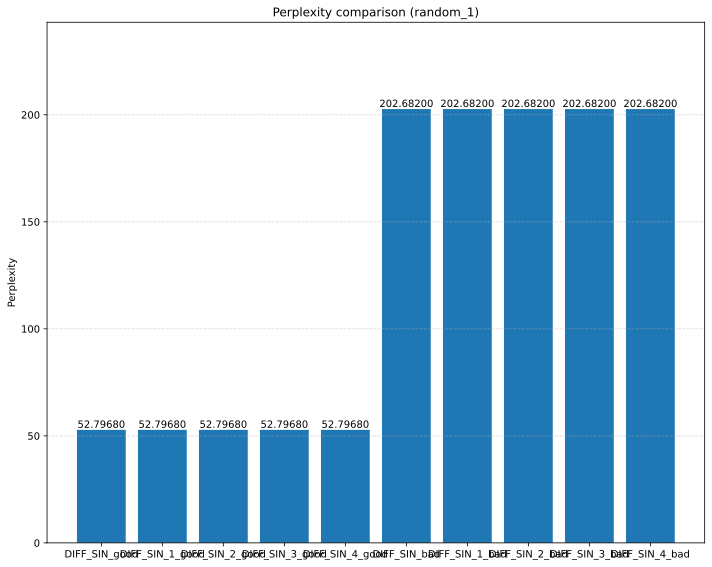

[[ 0.        0.        0.        0.        0.       12.239305  6.489005  9.552165  8.006815 15.375265]
 [ 0.        0.        0.        0.        0.       13.76751   8.01721  11.08037   9.53502  16.90347 ]
 [ 0.        0.        0.        0.        0.       19.03833  13.28803  16.35119  14.80584  22.17429 ]
 [ 0.        0.        0.        0.        0.        8.13395   2.38365   5.44681   3.90146  11.26991 ]
 [ 0.        0.        0.        0.        0.       12.07522   6.32492   9.38808   7.84273  15.21118 ]
 [12.239305 13.76751  19.03833   8.13395  12.07522   0.        0.        0.        0.        0.      ]
 [ 6.489005  8.01721  13.28803   2.38365   6.32492   0.        0.        0.        0.        0.      ]
 [ 9.552165 11.08037  16.35119   5.44681   9.38808   0.        0.        0.        0.        0.      ]
 [ 8.006815  9.53502  14.80584   3.90146   7.84273   0.        0.        0.        0.        0.      ]
 [15.375265 16.90347  22.17429  11.26991  15.21118   0.        0.        

c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


[[8.052573  7.32072  ]
 [8.68893   6.5316854]
 [8.149447  6.794362 ]
 [7.797011  5.8726926]
 [8.738077  7.2046022]
 [6.517409  6.297634 ]
 [7.128332  6.8831363]
 [7.048983  5.970059 ]
 [6.7018    5.5325727]
 [5.998009  5.860493 ]]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


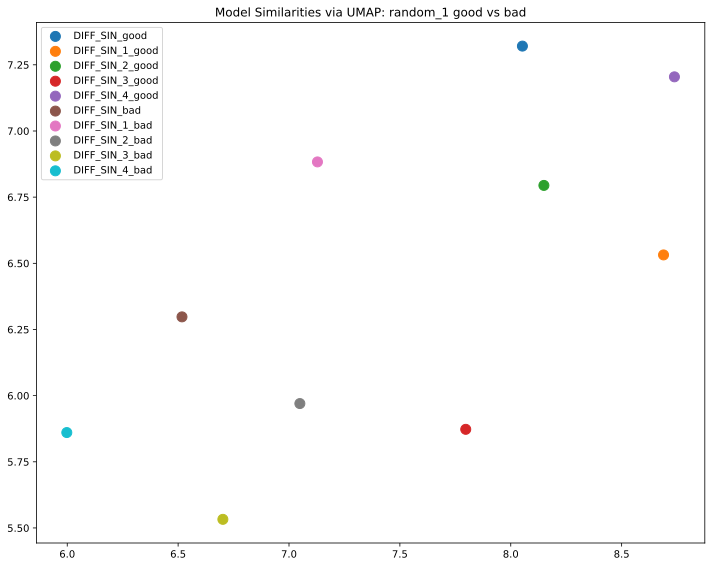

In [7]:
def plot_models_diff_random_1():

    random_config = ff.create_standard_config("random_1", dir="random")

    trainset_a = "random_1_400" # SINGLE performs really well here
    trainset_b = "random_1_450" # Single performs really bad here
    # ff.write_trainset(REBER_CONFIG, machines.reber(), trainset_name, 30)

    models = [
        Model(ModelType.SINGLE, "DIFF_SIN"),
        Model(ModelType.SINGLE, "DIFF_SIN_1"),
        Model(ModelType.SINGLE, "DIFF_SIN_2"),
        Model(ModelType.SINGLE, "DIFF_SIN_3"),
        Model(ModelType.SINGLE, "DIFF_SIN_4"),
        # Model(ModelType.ENSEMBLE, "DIFF_GREEDY", nrestimators=15, ens_mode=EnsMode.GREEDY, random_factor=2.5)
    ]

    runs = []
    # Train models with good data
    for model in models:
        run = model.into_run(trainset_name=trainset_a, run_name="good")
        runs.append(run)
    # Train models with bad data
    for model in models:
        run = model.into_run(trainset_name=trainset_b, run_name="bad")
        runs.append(run)

    ff.train_models_batch(random_config, runs, 12)

    plot_model_scores(random_config, runs, "random_1")

    scores_flat = ff.diff_models(random_config, trainset_a, [run.run_name for run in runs], nrestimators=10, sample_size=200)

    series = runs_into_series(runs)
    model_count = total_models(series)
    plot_nodes_by_distance(scores_flat, model_count, series=series , trainset="random_1 good vs bad", print_distances=True)

plot_models_diff_random_1()

In [47]:
def compute_imv(D: np.ndarray, square: bool = False):
    """
    Computes the Inter Model Variety metric given a distance matrix of the models.
    Currently this just returns the mean of all the pairwise distances of the matrix (upper triangle without the diagonal).
    """
    n = D.shape[0]
    if n < 2:
        return 0
    upper_tri_indices = np.triu_indices(n, k=1)
    pairwise_distances = D[upper_tri_indices]
    if square:
        return np.mean(pairwise_distances**2)
    else:
        return np.mean(pairwise_distances)

In [48]:
import matplotlib.cm
import matplotlib.colors


def plot_perplexity_vs_imv(scores: list[float], imvs: list[float], colors: list[float]|None = None, colrange: tuple[float, float] = (0.0, 7.0), title: str = "Ensemble Performance vs Diversity"):
    """
    Plots a scatterplot of perplexity (performance) vs inter-model variety (diversity).
    
    Parameters:
    - scores: List of ensemble perplexity values (lower is better).
    - imvs: List of inter-model variety (IMV) values (diversity metric).
    - title: Title of the plot.
    """
    if len(scores) != len(imvs):
        raise ValueError("Length of scores and imvs must be equal")

    Y = np.array(scores)
    X = np.array(imvs)

    plt.figure(figsize=(10, 8))
    if colors is None:
        plt.scatter(X, Y, s=50)
    else:    
        # min_color, max_color = min(colors), max(colors)
        C = np.array(colors)
        scatter = plt.scatter(X, Y, c=C, s=50, cmap="cool")
        cbar = plt.colorbar(scatter)
        cbar.set_label("Training Randomness", rotation=270, labelpad=15)

    # plt.axhline(y=Y[0], color='cyan', linewidth=1) # Baseline score for deterministic model
    plt.xlabel("Inter-Model Variety (IMV)")
    plt.ylabel("Perplexity (lower is better)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_perplexity_vs_imv_with_means(
        scores: list[float], 
        imvs: list[float], 
        colors: list[float], 
        colrange: tuple[float, float] = (0.0, 7.0), 
        title: str = "Mean Ensemble Performance vs Diversity"
    ):
    """
    Plots a separate scatterplot of mean IMV vs perplexity per group, with error bars (std dev).
    Assumes 'colors' identifies group membership (e.g., training randomness).
    """
    if not (len(scores) == len(imvs) == len(colors)):
        raise ValueError("scores, imvs, and colors must be the same length")

    # Data for the left subplot
    Y = np.array(scores)
    X = np.array(imvs)
    C = np.array(colors)

    # Group values by color
    grouped_x: dict[float, list[float]] = {c: [] for c in C}
    grouped_y: dict[float, list[float]] = {c: [] for c in C}

    for x, y, c in zip(X, Y, C):
        grouped_x[c].append(x)
        grouped_y[c].append(y)
    
    # Data for the right subplot
    C_keys = np.array(list(grouped_x.keys()))
    X_avg = [np.mean(xs) for xs in grouped_x.values()]
    X_std = [np.std(xs) for xs in grouped_x.values()]
    Y_avg = [np.mean(ys) for ys in grouped_y.values()]
    Y_std = [np.std(ys) for ys in grouped_y.values()]

    # Normalize color values
    norm = matplotlib.colors.Normalize(vmin=np.min(C_keys), vmax=np.max(C_keys))
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap="cool")

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

    # Left subplot: all data points
    scatter = ax1.scatter(X, Y, c=C, s=50, cmap="cool")
    ax1.set_title("All Models")
    ax1.set_xlabel("Inter-Model Variety (IMV)")
    ax1.set_ylabel("Perplexity (lower is better)")
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Right subplot: group means with error bars
    ax2.scatter(X_avg, Y_avg, c=C_keys, cmap="cool")
    ax2.set_title("Group Averages with Error Bars")
    ax2.set_xlabel("Inter-Model Variety (IMV)")
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Plot right subplot error bars
    for i, c in enumerate(C_keys):
        color = mapper.to_rgba(c)
        plt.errorbar(X_avg[i], Y_avg[i], xerr=X_std[i], yerr=Y_std[i], fmt='none', color=color, elinewidth=2, capsize=5)

    # Shared colorbar
    cbar = fig.colorbar(scatter, location="right", ax=[ax1, ax2])
    cbar.set_label("Training Randomness", rotation=270, labelpad=15)

    plt.suptitle(title, fontsize=14)
    # plt.tight_layout(rect=(0.0, 0.0, 0.97, 0.95))  # Leave space for colorbar and title
    plt.show()



def eval_diversity_vs_performance(
    machine = import_pdfa_json(input_file="./../models/random_1.json"),
    config = ff.create_standard_config("random_1", dir="random"),
    trainset_size = 300,
    testset_size = 1000,
    trainset = "random_1_300",
    testset = "random_1_1000",
    sample_size = 300,
    num_models = 24,
    num_runs_per_model = 5,
    min_rand = 0.1,
    max_rand = 7.0,
    nrestimators = 15,
    plot_means = False,
    skip_generate = False,
    skip_train = False,
    square_imv = False
):
    
    CLOCK.start()

    if not skip_generate:
        # Create train and test set
        print(f"Generating train and testsets: {trainset}, {testset}")
        ff.write_trainset(config, machine, trainset, trainset_size)
        ff.write_testset(config, machine, testset, testset_size)
    else:
        print(f"Skipped generating train and testsets: {trainset}, {testset}")

    # GREEDY models with varying randomness
    zero_model = Model(ModelType.ENSEMBLE, f"IMV_GREEDY_0", nrestimators=1, ens_mode=EnsMode.GREEDY, random_factor=0)
    models = [
        Model(ModelType.ENSEMBLE, f"IMV_GREEDY_{rand}", nrestimators=nrestimators, ens_mode=EnsMode.GREEDY, random_factor=rand)
        for rand in np.linspace(min_rand, max_rand, num_models)
    ]

    # Several random runs for each configuration and one run for the deterministic model
    runs: list[TrainRun] = []
    runs.append(zero_model.into_run(trainset_name=trainset, run_name="0"))
    for run_num in range(num_runs_per_model):
        for model in models:
            run = model.into_run(trainset_name=trainset, run_name=f"{run_num}")
            runs.append(run)

    # Train and test each model on the same trainset and testset
    if not skip_train:
        ff.train_models_batch(config, runs, CORES)
        print(f"Finished training {len(runs)} runs on {trainset}: {CLOCK.measure()}")
    else:
        print(f"Skipped training {len(runs)} runs on {trainset}")
    test_runs = TestRun.from_train_runs(runs, testset)
    scores = ff.test_models_batch(config, test_runs)
    print(f"Finished testing {len(runs)} runs on {testset}: {CLOCK.measure()}")
    
    # Now compute IMVs
    imvs = []
    diffs = ff.diff_models_batch(config, [run.run_name for run in runs], train_name=trainset, nrestimators=nrestimators, sample_size=sample_size)
    for flat_array, run in zip(diffs, runs):
        D = scores_flat_to_normalized_distance_matrix(flat_array, run.model.nrestimators)
        imv = compute_imv(D, square=square_imv)
        imvs.append(imv)
    print(f"Finished diffing {len(runs)}, smaple_size={sample_size}: {CLOCK.measure()}")
    print(f"Total time: {CLOCK.stop()}")

    # Colors
    colors = [run.model.random_factor for run in runs]

    # Plot the scores
    if plot_means:
        plot_perplexity_vs_imv_with_means(scores, imvs, colors=colors, colrange=(0.0, max_rand), title=f"Ensemble Performance vs Diversity ({config.name})")
    else:
        plot_perplexity_vs_imv(scores, imvs, colors=colors, colrange=(0.0, max_rand), title=f"Ensemble Performance vs Diversity ({config.name})")


Finished training 46 runs on random_1_300: 1m 0s
Finished testing 46 runs on random_1_1000: 0m 49s
Finished diffing 46, smaple_size=300: 0m 11s
Total time: 2m 1s


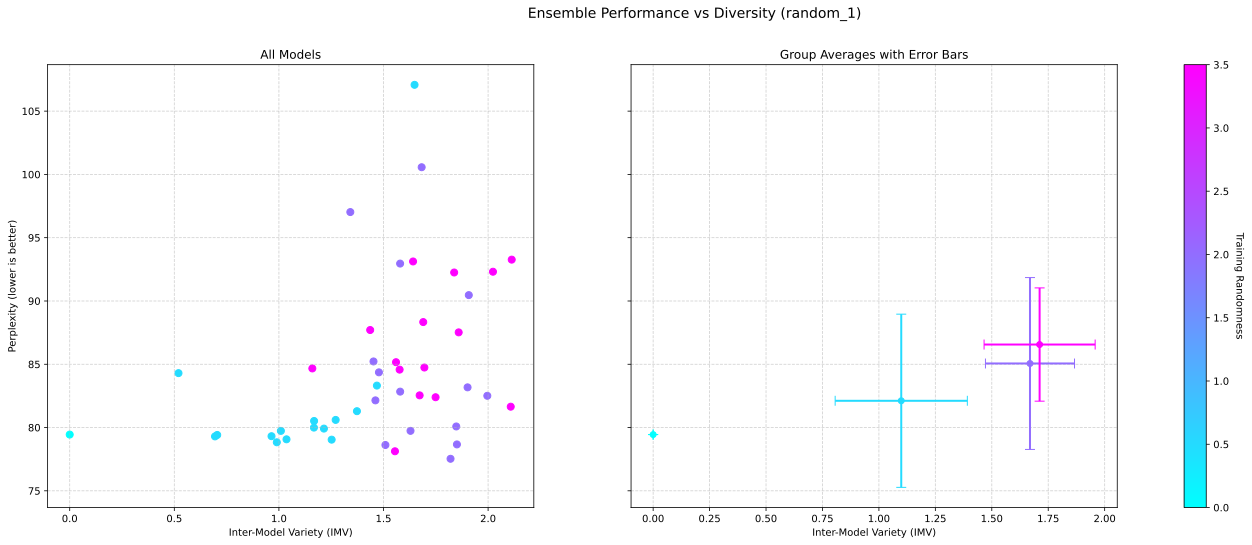

In [36]:
eval_diversity_vs_performance(num_models=3, num_runs_per_model=15, max_rand=3.5, min_rand=0.5, nrestimators=10, plot_means=True)

Finished training 120 runs on random_1_300
Finished testing 120 runs on random_1_1000
Finished diffing 120, smaple_size=300


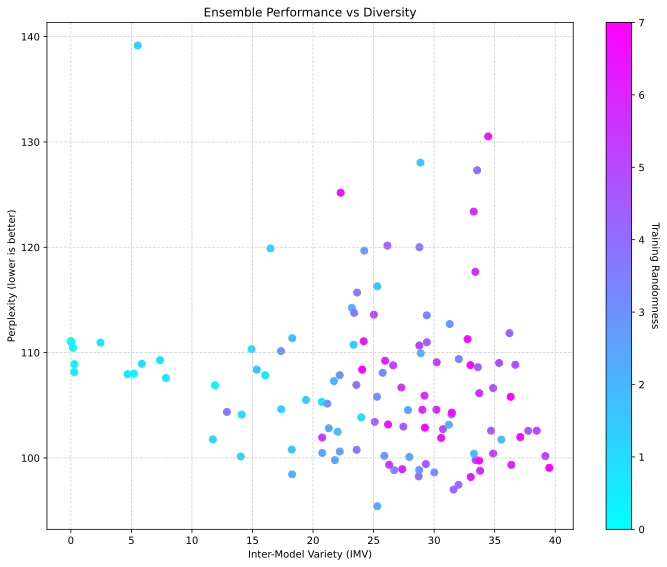

In [28]:
eval_diversity_vs_performance()

Skipped generating train and testsets: reber_30, reber_400
Skipped training 201 runs on reber_30
Finished testing 201 runs on reber_400: 0m 19s
Finished diffing 201, smaple_size=300: 0m 10s
Total time: 0m 30s


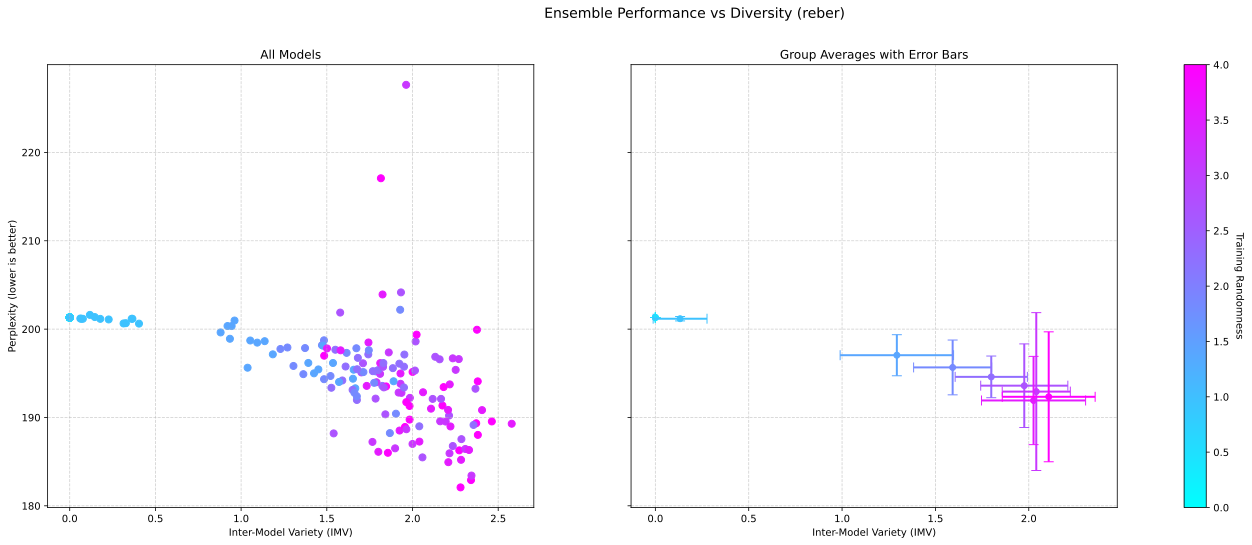

In [49]:
eval_diversity_vs_performance(
    machine=machines.reber(), 
    config=REBER_CONFIG, 
    trainset_size=30, 
    trainset="reber_30",
    testset_size=400,
    testset="reber_400",
    num_models=10,
    num_runs_per_model=20,
    max_rand=4,
    skip_generate=True,
    skip_train=True,
    plot_means=True,
    square_imv=True
)

Generated 9 train sets and a test set
Training 18 run configurations completed
Testing 18 run configurations on random_3 completed


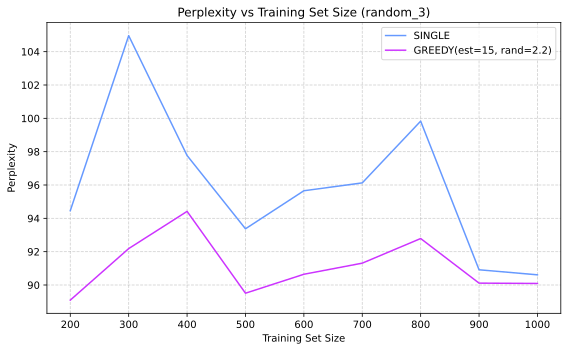

In [41]:
# Now evaluate random 3
def evaluate_random_3():

    train_sizes = [i for i in range(200, 1001, 100)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, rand=2.2)
    ]
    evaluate_models_by_train_size(RANDOM_CONFIG(3), RANDOM_MACHINE(3), models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_3()

Skipped generating train and testsets: random_3_300, random_3_1000
Skipped training 41 runs on random_3_300
Finished testing 41 runs on random_3_1000: 0m 11s
Finished diffing 41, smaple_size=300: 0m 5s
Total time: 0m 17s


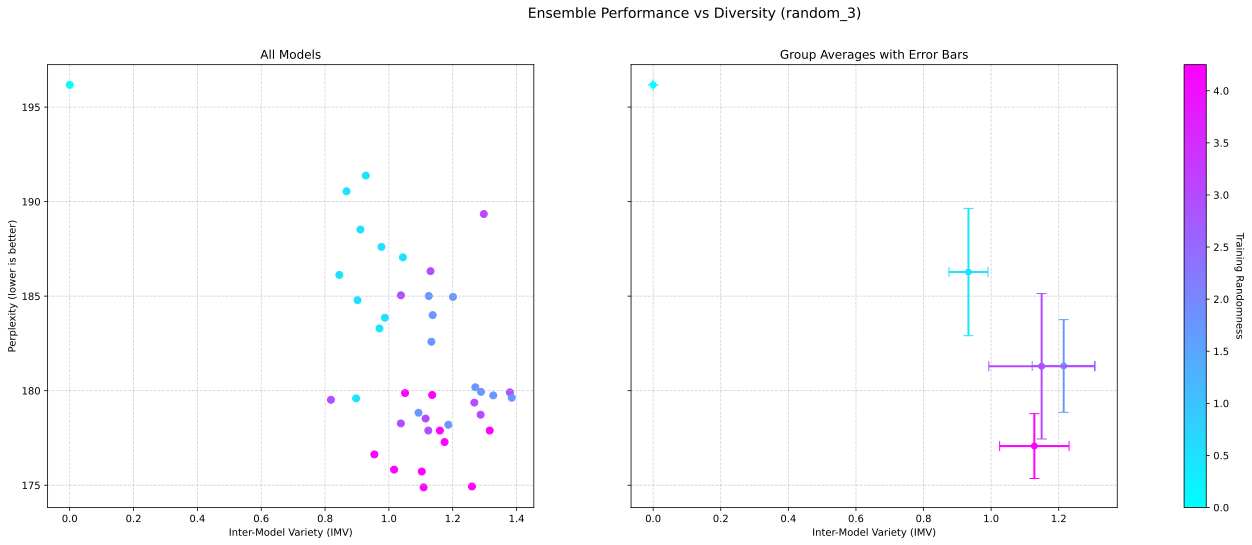

In [45]:
eval_diversity_vs_performance(
    machine=RANDOM_MACHINE(3), 
    config=RANDOM_CONFIG(3), 
    trainset_size=300, 
    trainset="random_3_300",
    testset_size=1000,
    testset="random_3_1000",
    num_models=4,
    num_runs_per_model=10,
    min_rand=0.5,
    max_rand=4.25,
    skip_generate=True,
    skip_train=True,
    plot_means=True
)